# **Projet DataScientest**
## Analyse exploratoire des données
---


### **1. Chargement des libraries**

On charge les différentes librairies utiles pour l'analyse exploratoire.

In [1]:
# import des libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib import offsetbox
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from math import ceil
from PIL import Image
import os
import re
import warnings

#tests parallélisation 
from numba import njit, prange

warnings.filterwarnings("ignore")
%matplotlib inline

custom_params = {"axes.spines.right": False,
                 "axes.spines.left": False,
                 "axes.spines.top": False}

sns.set_theme(style="white", 
              palette='magma', 
              rc=custom_params)

In [2]:
libraries = ['pandas', 'numpy', 'matplotlib']
versions = [pd.__version__, np.__version__, matplotlib.__version__]
print('######## Versions ########')
for i in range(len(libraries)):
    print(f'# {libraries[i] : <12}=>{versions[i] : >8} #')
print('##########################')   

######## Versions ########
# pandas      =>   1.2.5 #
# numpy       =>  1.22.0 #
# matplotlib  =>   3.5.1 #
##########################


On prépare ici les différents chemins vers les répertoires ou fichiers.

In [3]:
ROOT = '/media/gael/DATA_2/Projet_DataScientest/data/raw/annotated_regions/' # Je s'appelle Root
TARGET_PATH = '/media/gael/DATA_2/Projet_DataScientest/data/raw/train_annotations.csv' # Chemin à changer en fonction de l'utilisateur
RAW = '/media/gael/DATA_2/Projet_DataScientest/data/raw/'
RESIZED = '/media/gael/DATA_2/Projet_DataScientest/data/raw/resized_regions/'

### **2. Analyse du fichier *train_annotations.csv***

In [4]:
# On affiche les premières lignes
target = pd.read_csv(TARGET_PATH)
target.head()

,annotation_id,filename,annotation_class
0,C12_B132_S12_0,C12_B132_S12.tif,2
1,C12_B132_S12_1,C12_B132_S12.tif,3
2,C12_B132_S12_2,C12_B132_S12.tif,3
3,C12_B132_S12_3,C12_B132_S12.tif,3
4,C12_B132_S12_4,C12_B132_S12.tif,3


In [5]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5926 entries, 0 to 5925
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   annotation_id     5926 non-null   object
 1   filename          5926 non-null   object
 2   annotation_class  5926 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 139.0+ KB


### **2.1. Correction des noms de fichiers**
On constate que la colonne *filename* ne contient pas les bons noms de fichiers.
Le nom correct est obtenu à partir de la colonne *annotation_id* en ajoutant l'extension *jpeg*.

In [6]:
# vérif extensions
target['filename'].apply(lambda x : str(x).split('.')[1]).unique()

array(['tif'], dtype=object)

In [7]:
# On applique la modification de l'extension .tif => .jpeg
target['filename']  = target['annotation_id'].apply(lambda x: str(x)+'.jpeg')

# Vérification 
target['filename'].head()

0    C12_B132_S12_0.jpeg
1    C12_B132_S12_1.jpeg
2    C12_B132_S12_2.jpeg
3    C12_B132_S12_3.jpeg
4    C12_B132_S12_4.jpeg
Name: filename, dtype: object

### **2.2. Ananlyse de la distribution des différentes classes**

On analyse la répartition des grades.

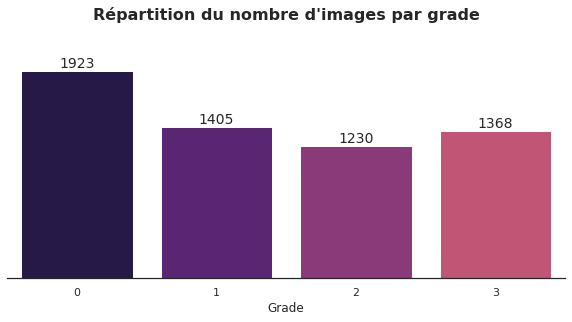

In [8]:
plt.figure(figsize=(10,4))
ax = sns.countplot(data=target, 
              x='annotation_class')
ax.bar_label(ax.containers[0],
             fontsize=14)
plt.ylabel('')
plt.yticks([])
plt.xlabel('Grade')
plt.title("Répartition du nombre d'images par grade\n\n", 
          fontdict={'fontsize':16,
                    'fontweight':'bold'})
plt.show()

On crée une nouvelle feature pour savoir si l'image contient des cellules cancereuses ou pas.

In [9]:
target['binary_class'] = target['annotation_class'].apply(lambda x: 0 if x==0 else 1)

In [10]:
pd.crosstab(target['binary_class'], target['annotation_class'])

annotation_class,0,1,2,3
binary_class,,,,
0,1923,0,0,0
1,0,1405,1230,1368


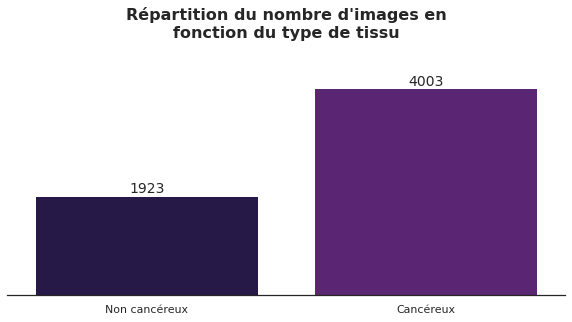

In [11]:
plt.figure(figsize=(10,4))
ax = sns.countplot(data=target, 
              x='binary_class')
ax.bar_label(ax.containers[0],
             fontsize=14)
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
plt.xticks(ticks=[0,1], 
           labels=['Non cancéreux', 'Cancéreux'])
plt.title("Répartition du nombre d'images en\nfonction du type de tissu\n\n", 
          fontdict={'fontsize':16,
                    'fontweight':'bold'})
plt.show()

Le jeu données contient moins de données de tissus sains que cancéreux. Il faudra peut-être corriger cet aspect au moment de la création des jeux de train et test.

### **2.3. Ajout de métadonnées supplémentaires**

On ajoute de nouvelles colonnes contenant les informations contenues dans le nom du fichier :
> * *CXX* : numéro de centre
> * *BXX_SXX* : numéro de lame
> * *XXX* : id de l'image

In [12]:
# On ajoute le numéro du centre
target['id_centre'] = target['filename'].apply(lambda x: str(x).split('_')[0])

In [13]:
# On ajoute le numéro de lame
re_lame = re.compile(r'([B-C][0-9]{3}_S[0-9]{2})')
target['id_lame'] = target['filename'].str.extract(re_lame)

In [14]:
# On ajoute, pour une lame donnée, l'identifiant
target['id_image'] = target['filename'].apply(lambda x: str(x).split('_')[-1].split('.')[0])

In [15]:
# On intègre la taille des images
target['img_col_dim']=target['filename'].apply(lambda x: torchvision.io.read_image(ROOT+x).numpy().shape[0]).astype('int')

In [16]:
target['img_width']=target['filename'].apply(lambda x: torchvision.io.read_image(ROOT+x).numpy().shape[1]).astype('int')

In [17]:
target['img_height']=target['filename'].apply(lambda x: torchvision.io.read_image(ROOT+x).numpy().shape[2]).astype('int')

In [18]:
target.head()

,annotation_id,filename,annotation_class,binary_class,id_centre,id_lame,id_image,img_col_dim,img_width,img_height
0,C12_B132_S12_0,C12_B132_S12_0.jpeg,2,1,C12,B132_S12,0,3,1304,1304
1,C12_B132_S12_1,C12_B132_S12_1.jpeg,3,1,C12,B132_S12,1,3,1304,1304
2,C12_B132_S12_2,C12_B132_S12_2.jpeg,3,1,C12,B132_S12,2,3,1304,1304
3,C12_B132_S12_3,C12_B132_S12_3.jpeg,3,1,C12,B132_S12,3,3,1304,1304
4,C12_B132_S12_4,C12_B132_S12_4.jpeg,3,1,C12,B132_S12,4,3,1304,1304


### **2.4. Taille d'images par centre**

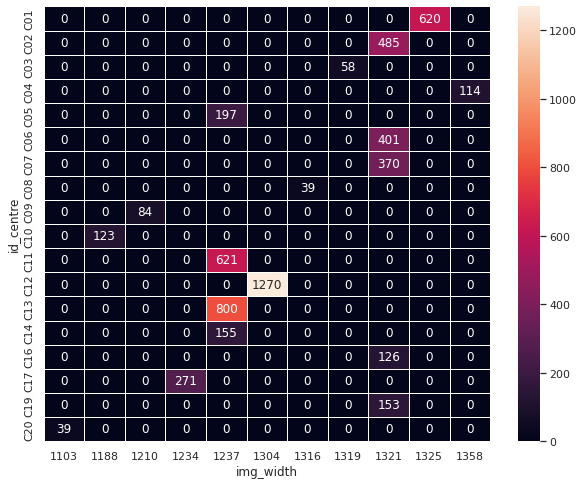

In [19]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.crosstab(target['id_centre'], target['img_width']), 
            annot=True, 
            fmt='d', 
            linewidths=0.5, 
            #cbar_kws={"orientation": "horizontal"},
            )
plt.show()

In [20]:
new_data = pd.DataFrame(data=target.groupby('id_centre')['filename'].count()).reset_index()
new_data.columns = ['id_centre', 'total']

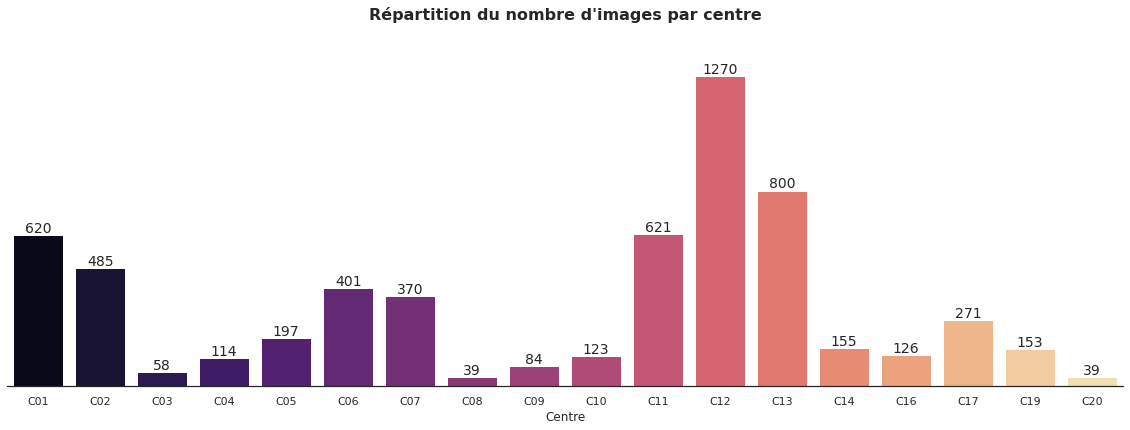

In [21]:
plt.figure(figsize=(20,6))
ax = sns.barplot(data=new_data, 
                 palette='magma',
                 x='id_centre',
                 y='total')
ax.bar_label(ax.containers[0],
             fontsize=14)
plt.ylabel('')
plt.yticks([])
plt.xlabel('Centre')
plt.title("Répartition du nombre d'images par centre\n\n", 
          fontdict={'fontsize':16,
                    'fontweight':'bold'})
plt.show()

In [22]:
new_data = new_data.sort_values(by=['total'], ascending=False)

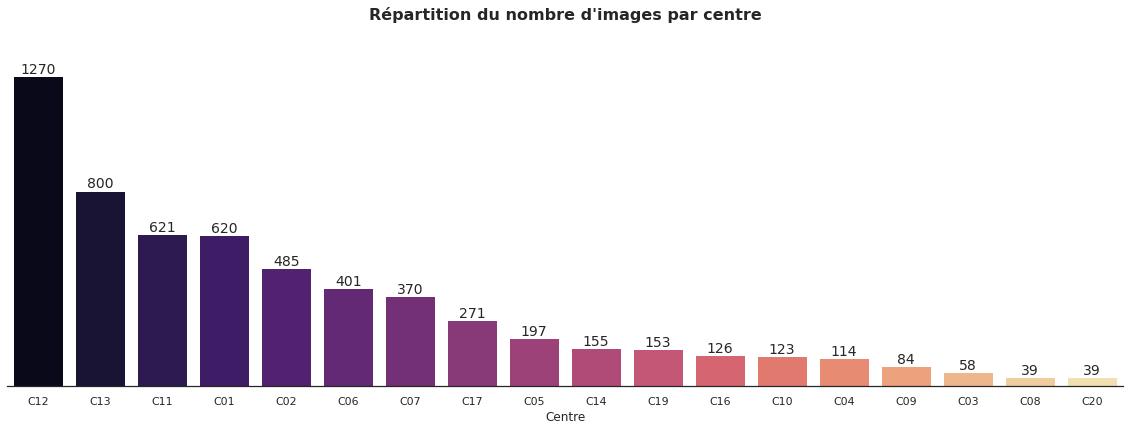

In [23]:
plt.figure(figsize=(20,6))
ax = sns.barplot(data=new_data, 
                 palette='magma',
                 x='id_centre',
                 y='total')
ax.bar_label(ax.containers[0],
             fontsize=14)
plt.ylabel('')
plt.yticks([])
plt.xlabel('Centre')
plt.title("Répartition du nombre d'images par centre\n\n", 
          fontdict={'fontsize':16,
                    'fontweight':'bold'})
plt.show()

### **2.5 Nombre de grades par lame**

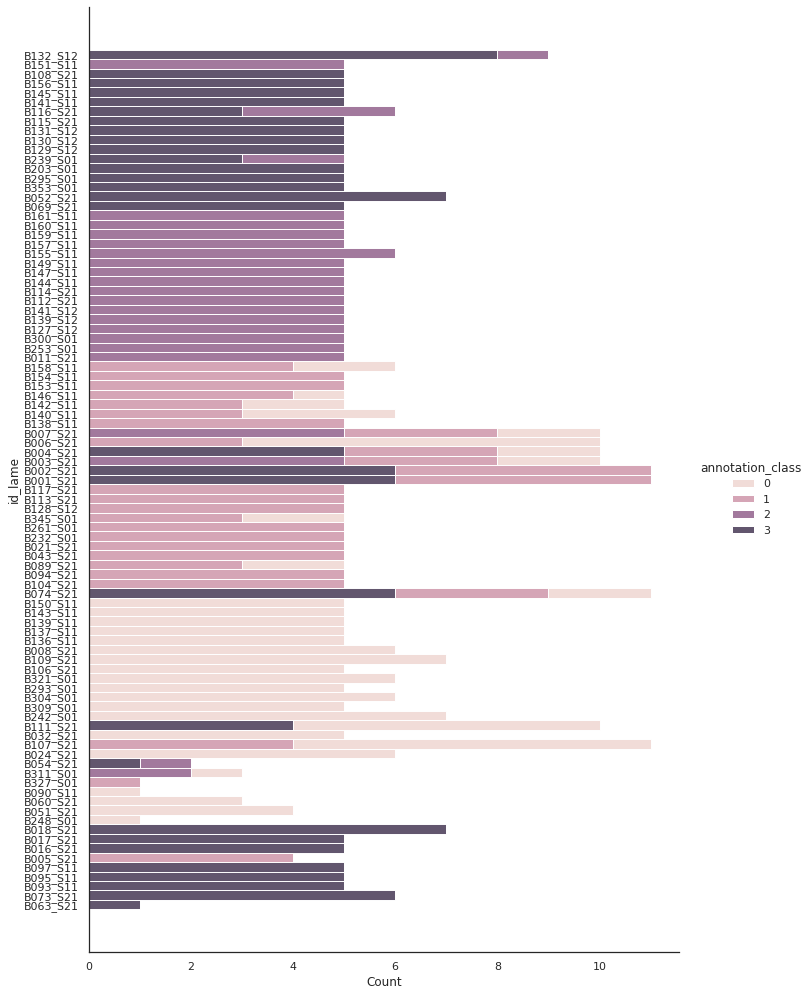

In [24]:
sns.displot(data=target[0:500], 
            y='id_lame', 
            multiple='stack', 
            hue='annotation_class',
            height=14,
            aspect=0.7,
            #palette='magma'
           )

In [25]:
test = target.groupby(['id_lame', 'annotation_class']).agg(nb_ech_par_lame=('filename', 'count')).reset_index()

In [26]:
test

,id_lame,annotation_class,nb_ech_par_lame
0,B001_S03,0,7
1,B001_S08,1,5
2,B001_S09,0,5
3,B001_S20,1,2
4,B001_S21,0,7
...,...,...,...
1126,B605_S12,2,5
1127,C015_S11,2,8
1128,C025_S11,3,5
1129,C049_S11,1,2


In [27]:
from random import sample
test2 = target[:300]

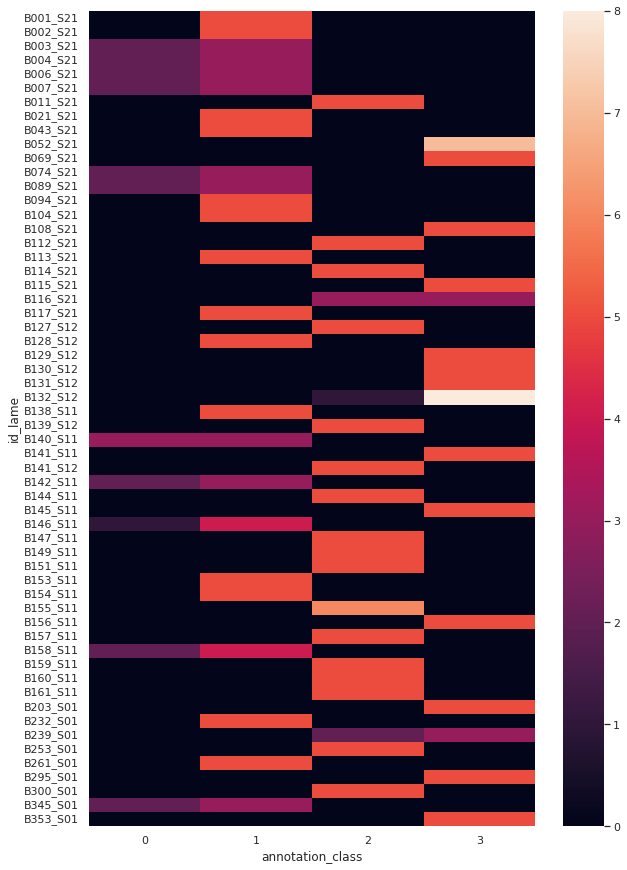

In [28]:
plt.figure(figsize=(10,15))
sns.heatmap(pd.crosstab(test2['id_lame'], test2['annotation_class']), 
            #annot=True
           )
plt.show()

### **Création d'un nouveau fichier de labels (jpeg)**

In [19]:
filenames = [name for name in os.listdir(ROOT) if os.path.splitext(name)[-1] == '.jpeg']
filenames.sort()

In [20]:
liste = []
label_df = target[['filename', 'binary_class']].sort_values(by='filename')
for i, name in enumerate(filenames):
    test = name == label_df.iloc[i]['filename']
    liste.append(test)

print('Longueur de la liste des fichiers : ', len(filenames))
print('Nombre de tests OK : ', sum(liste))

Longueur de la liste des fichiers :  5926
Nombre de tests OK :  5926


In [21]:
label_df.reset_index(drop=True).to_csv(RAW+'label_df.csv', index=False)

### **6. Exploration des images**

#### 6.1. Affichage d'un échantillon d'images random

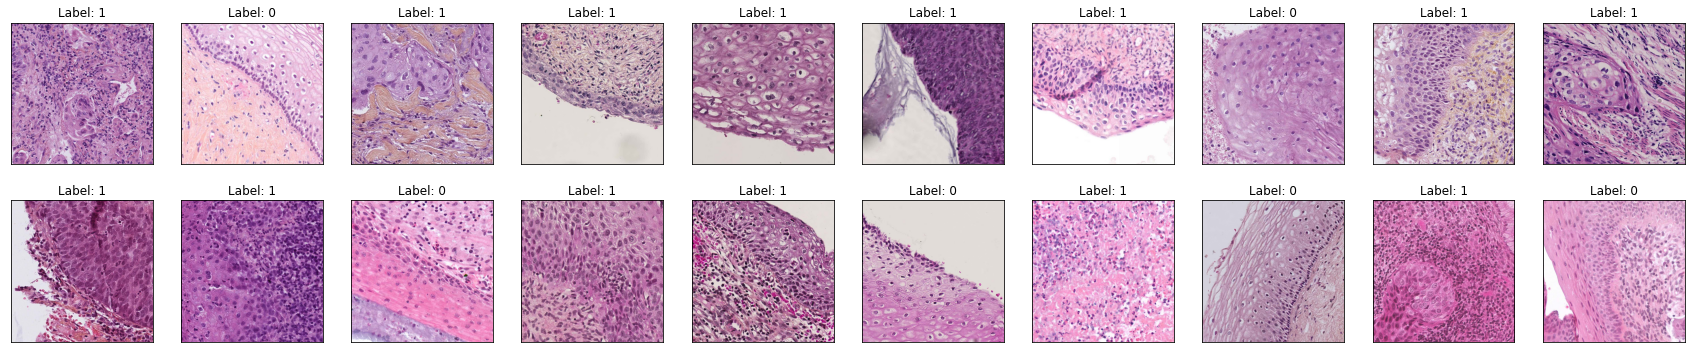

In [3]:
full_train_df = pd.read_csv(RAW+'label_df.csv')

fig = plt.figure(figsize=(30, 6))
# display 20 images
all_imgs = os.listdir(RESIZED)
#print(train_imgs[:10])
for idx, img in enumerate(np.random.choice(all_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(RESIZED + img)
    plt.imshow(im)
    lab = full_train_df.loc[full_train_df['filename'] == img, 'binary_class'].values[0]
    ax.set_title('Label: %s'%lab)

#### 6.2 Conversion des images en matrices

In [4]:
mask = full_train_df['binary_class']==1
avec_cancer = full_train_df[mask]
sans_cancer = full_train_df[~mask]

In [5]:
sans_cancer.head()

,filename,binary_class
4,C01_B008_S01_0.jpeg,0
5,C01_B008_S01_1.jpeg,0
6,C01_B008_S01_2.jpeg,0
7,C01_B008_S01_3.jpeg,0
8,C01_B008_S01_4.jpeg,0


In [6]:
avec_cancer.head()

,filename,binary_class
0,C01_B003_S01_0.jpeg,1
1,C01_B003_S01_1.jpeg,1
2,C01_B003_S01_2.jpeg,1
3,C01_B003_S01_3.jpeg,1
14,C01_B027_S01_2.jpeg,1


In [7]:
vec_sans_cancer = []
for i in sans_cancer.index[:1000]:
    t = torchvision.io.read_image(RESIZED+sans_cancer.loc[i,'filename'])
    vec_sans_cancer.append(t.numpy())

In [8]:
img = np.mean(vec_sans_cancer, axis=0).astype(int)

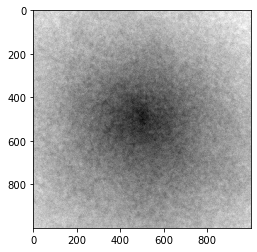

In [86]:
# Calcul de l'image moyenne
plt.imshow(#torch.Tensor(img.astype(int)).permute(1,2,0)[...,::-1],
           img[0,:,:], 
           cmap='gray', 
           interpolation='None');

In [49]:
avec_avec_cancer = []
for i in avec_cancer.index[:1000]:
    t = torchvision.io.read_image(RESIZED+avec_cancer.loc[i,'filename'])
    avec_avec_cancer.append(t.numpy())

In [50]:
img_cancer = np.mean(avec_avec_cancer, axis=0).astype(int)

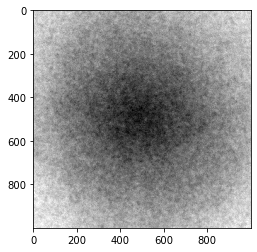

In [51]:
plt.imshow(img_cancer[0,:,:], cmap='gray', interpolation='None')

#### 6.3 Essai PCA et eigenimages

In [7]:
pca_sain = []
for i in sans_cancer.index[:250]:
    t = torchvision.io.read_image(RESIZED+sans_cancer.loc[i,'filename'])
    t_gs = transforms.functional.rgb_to_grayscale(t)
    pca_sain.append(t_gs.ravel().numpy())

In [8]:
df_pca_sain = pd.DataFrame(data=pca_sain)
df_pca_sain.head()

,0,1,2,3,4,5,6,7,8,9,...,999990,999991,999992,999993,999994,999995,999996,999997,999998,999999
0,24,25,26,28,30,32,35,36,88,99,...,153,155,158,143,132,129,124,118,123,134
1,33,23,20,26,25,18,19,27,14,14,...,71,65,62,58,54,53,54,56,55,53
2,60,61,56,47,44,45,44,38,48,46,...,64,61,81,117,123,111,110,83,46,38
3,119,111,105,102,90,78,78,88,90,101,...,143,139,141,180,204,193,182,191,198,194
4,109,93,72,60,59,62,62,60,74,75,...,173,173,170,167,164,166,171,173,170,167


In [9]:
pca = PCA(n_components = 0.99)
pca.fit(df_pca_sain)

PCA(n_components=0.99)

In [10]:
pca.n_components_

233

In [11]:
def plot_pca(pca):
    # plot eigenimages in a grid
    n = 81#pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(1000,1000), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()

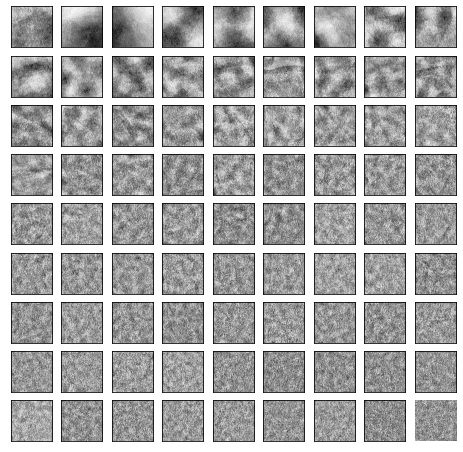

In [12]:
plot_pca(pca)

In [48]:
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray_r', prefit = False):
    ax = ax or plt.gca()
    
    if not prefit :
        proj = model.fit_transform(data)
    else:
        proj = data
    ax.plot(proj[:, 0], proj[:, 1], '.b')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # On ne montre pas le points trop proches
                continue
            # Modification du code pour rédurie la taille de l'image
            test = np.moveaxis(images[i], 0, -1)
            #print(test.shape)
            #print(type(test))
            test=Image.fromarray(test[:,:,0], mode='L').resize((80,80))
            test=np.array(test) 
            # Fin modification
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(test,
                                      #images[i], 
                                      cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

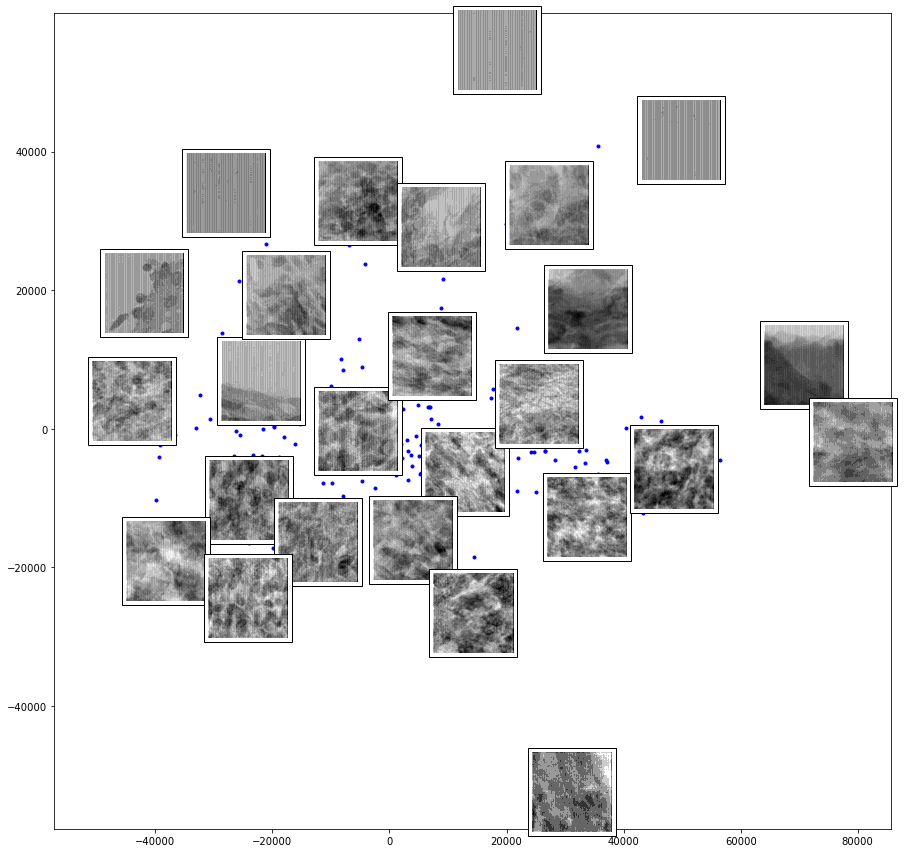

In [51]:
fig, ax = plt.subplots(figsize=(15, 15))

plot_components(df_pca_sain,
                model=PCA(n_components=2),
                images=np.array(df_pca_sain).reshape((-1, 1, 1000, 1000)),
                cmap = 'gray',
                thumb_frac = .1)

#### 6.4 Analyse colorimétrique

In [69]:
print('Stats tissus cancereux : ')
print('************************')
print(f'Intensité min : {img_cancer.min() : >5}')
print(f'Intensité max : {img_cancer.max() : >5}')
print(f'Intensité moy : {img_cancer.mean().astype(int) : >5}')
print('Stats tissus sains :')
print('************************')
print(f'Intensité min : {img.min() : >5}')
print(f'Intensité max : {img.max() : >5}')
print(f'Intensité moy : {img.mean().astype(int) : >5}')

Stats tissus cancereux : 
************************
Intensité min :   109
Intensité max :   179
Intensité moy :   151
Stats tissus sains :
************************
Intensité min :   124
Intensité max :   198
Intensité moy :   168


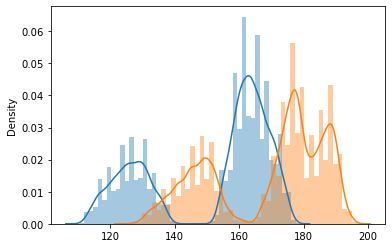

In [59]:
sns.distplot(img_cancer)
sns.distplot(img)
plt.show();

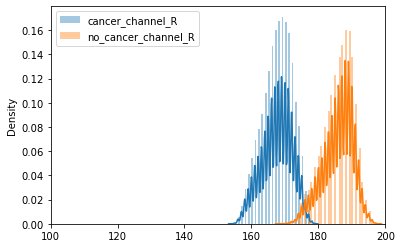

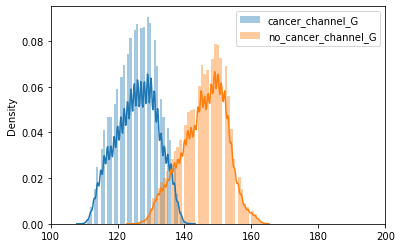

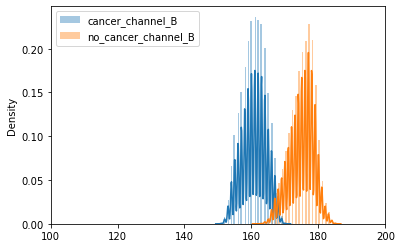

In [87]:
color = ['R', 'G', 'B']
for i in range(3):
    sns.distplot(img_cancer[i,:,:], label='cancer_channel_'+str(color[i]))
    sns.distplot(img[i,:,:], label='no_cancer_channel_'+str(color[i]))
    plt.legend()
    plt.xlim((100,200))
    plt.show();